# Brain Tumor MRI Segmentation
## Introduction

Brain tumors are life-threatening conditions that require early and accurate diagnosis. Manual annotation of MRI scans is time-consuming and prone to human error.
This project focuses on:

Segmentation of tumor regions using deep learning.

We employ an *U-Net* based transfer learning (*EfficientNet*) segmentation model, trained and evaluated on a custom made subset of the BraTS2020 datasets.

In [2]:
import os
import cv2
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

In [3]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_dir, mask_dir, augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

        # agumentation
        self.transform = A.Compose([
            A.Resize(256, 256),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(p=0.2),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2()
        ]) if augment else A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # load
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # resize
        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # apply augmentations
        augmented = self.transform(image=image, mask=mask)
        image = augmented["image"]
        mask = augmented["mask"]

        # convert to tensors
        image = image.float() / 255.0  

        # map mask to 0..3
        mask = (mask // 85).long()

        return image, mask



## Model Architecture
### Classification Model

**Segmentation Model**

- Architecture: U-Net
- Encoder: *EfficientNetB0* (pretrained on ImageNet)
- Decoder: Transposed convolutions
- Loss Functions: Dice Loss + Cross Entropy Loss

In [4]:
def get_model():
    model = smp.Unet(
    encoder_name="timm-efficientnet-b0", #resnet18
    encoder_weights="imagenet",
    in_channels=1,
    classes=4
    )
    return model

## Metrics

- Dice Coefficient:
- IoU (Intersection over Union):


In [5]:
def dice_score(outputs, targets, num_classes=4, epsilon=1e-7):
    """ Multi-class Dice score (macro average). """
    outputs = torch.softmax(outputs, dim=1)      
    preds = torch.argmax(outputs, dim=1)         

    dice_per_class = []
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        true_cls = (targets == cls).float()

        intersection = (pred_cls * true_cls).sum()
        union = pred_cls.sum() + true_cls.sum()

        dice = (2 * intersection + epsilon) / (union + epsilon)
        dice_per_class.append(dice.item())

    return sum(dice_per_class) / num_classes


def iou_score(outputs, targets, num_classes=4, epsilon=1e-7):
    """ Multi-class IoU (macro average). """
    outputs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(outputs, dim=1)

    iou_per_class = []
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        true_cls = (targets == cls).float()

        intersection = (pred_cls * true_cls).sum()
        union = pred_cls.sum() + true_cls.sum() - intersection

        iou = (intersection + epsilon) / (union + epsilon)
        iou_per_class.append(iou.item())

    return sum(iou_per_class) / num_classes


class WeightedCE_DiceLoss(nn.Module):
    def __init__(self, class_weights=None, smooth=1e-6):
        super().__init__()
        self.class_weights = class_weights
        self.smooth = smooth

    def forward(self, inputs, targets):
        """
        inputs: [B, C, H, W]  (softmax probs)
        targets: [B, H, W]    (long, class labels)
        """
        # Cross Entropy with weights
        ce = F.cross_entropy(inputs, targets, weight=self.class_weights)

        # Dice Loss (per class)
        probs = F.softmax(inputs, dim=1)
        targets_onehot = F.one_hot(targets, num_classes=probs.shape[1]).permute(0,3,1,2).float()

        intersection = (probs * targets_onehot).sum(dim=(2,3))
        dice = (2.*intersection + self.smooth) / (probs.sum(dim=(2,3)) + targets_onehot.sum(dim=(2,3)) + self.smooth)
        dice_loss = 1 - dice.mean()

        return 0.5* (ce + dice_loss)



In [32]:
def train_model(model, modality, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device, best_loss=1):
    history = {"train_loss": [], "val_loss": [], "val_dice": [], 'val_iou': []}

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for imgs, masks in train_loader:
                imgs, masks = imgs.to(device), masks.to(device)

                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                loss.backward()


                optimizer.step()

                running_loss += loss.item()
                pbar.update(1)

        avg_train_loss = running_loss / len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss, val_dice, val_iou = 0.0, 0.0, 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)

                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_dice += dice_score(outputs, masks)
                val_iou += iou_score(outputs, masks)

        
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_iou  = val_iou / len(val_loader)
        
        scheduler.step(avg_val_loss)
        
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_dice"].append(avg_val_dice)
        history["val_iou"].append(avg_val_iou)

        print(f"Epoch {epoch+1}/{epochs} "
              f"- Train Loss: {avg_train_loss:.4f} "
              f"- Val Loss: {avg_val_loss:.4f} "
              f"- Val Dice: {avg_val_dice:.4f} "
              f"- Val IoU: {avg_val_iou:.4f}")


        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            save_path = f"{modality}_unet.pth" #os.path.join()  "kaggle", "working",
            torch.save(model.state_dict(), save_path)


    return history

In [25]:
def train_one_modality(
    modality, 
    root_dir="/kaggle/input/brats20-sampled-subset-png/dataset", 
    epochs=10, 
    batch_size=8, 
    lr=1e-4, 
    device="cuda",
    weights_path=False   
):
    img_dir = os.path.join(root_dir, modality, "images")
    mask_dir = os.path.join(root_dir, modality, "masks")

    dataset = BrainMRIDataset(img_dir, mask_dir, augment=True)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=False
    )

    # Initialize model
    model = get_model().to(device)

    # Load weights if provided
    if weights_path and os.path.exists(weights_path):
        print(f"Loading pretrained weights from {weights_path}")
        model.load_state_dict(torch.load(weights_path, map_location=device))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    weights = torch.tensor([0.2, 1.0, 1.0, 1.0], device=device)
    criterion = WeightedCE_DiceLoss(class_weights=weights).to(device)

    return train_model(
        model, modality, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device
    )


## Training & Results

In [8]:
histories = {}
modalities = ["flair", "t1", "t1ce", "t2"]

In [18]:
m = modalities[0]
hist = train_one_modality(m, epochs=30, batch_size=32, lr=1e-4)
histories[m] = hist
print(f"\nfinished training {m}\n")

Epoch 1/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 1/30 - Train Loss: 0.8463 - Val Loss: 0.6208 - Val Dice: 0.4259 - Val IoU: 0.3521


Epoch 2/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 2/30 - Train Loss: 0.5446 - Val Loss: 0.4913 - Val Dice: 0.4663 - Val IoU: 0.3801


Epoch 3/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 3/30 - Train Loss: 0.4679 - Val Loss: 0.4447 - Val Dice: 0.5391 - Val IoU: 0.4309


Epoch 4/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 4/30 - Train Loss: 0.4320 - Val Loss: 0.4408 - Val Dice: 0.4905 - Val IoU: 0.3941


Epoch 5/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 5/30 - Train Loss: 0.4126 - Val Loss: 0.4078 - Val Dice: 0.5652 - Val IoU: 0.4529


Epoch 6/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 6/30 - Train Loss: 0.3993 - Val Loss: 0.3973 - Val Dice: 0.5750 - Val IoU: 0.4604


Epoch 7/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 7/30 - Train Loss: 0.3905 - Val Loss: 0.3934 - Val Dice: 0.5683 - Val IoU: 0.4562


Epoch 8/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 8/30 - Train Loss: 0.3825 - Val Loss: 0.3849 - Val Dice: 0.6066 - Val IoU: 0.4869


Epoch 9/30: 100%|██████████| 136/136 [00:35<00:00,  3.79batch/s]


Epoch 9/30 - Train Loss: 0.3764 - Val Loss: 0.3818 - Val Dice: 0.6121 - Val IoU: 0.4911


Epoch 10/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 10/30 - Train Loss: 0.3723 - Val Loss: 0.3782 - Val Dice: 0.6263 - Val IoU: 0.5038


Epoch 11/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 11/30 - Train Loss: 0.3682 - Val Loss: 0.3803 - Val Dice: 0.6182 - Val IoU: 0.4964


Epoch 12/30: 100%|██████████| 136/136 [00:35<00:00,  3.79batch/s]


Epoch 12/30 - Train Loss: 0.3652 - Val Loss: 0.3736 - Val Dice: 0.6356 - Val IoU: 0.5127


Epoch 13/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 13/30 - Train Loss: 0.3600 - Val Loss: 0.3720 - Val Dice: 0.6455 - Val IoU: 0.5218


Epoch 14/30: 100%|██████████| 136/136 [00:35<00:00,  3.79batch/s]


Epoch 14/30 - Train Loss: 0.3579 - Val Loss: 0.3733 - Val Dice: 0.6389 - Val IoU: 0.5171


Epoch 15/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 15/30 - Train Loss: 0.3567 - Val Loss: 0.3712 - Val Dice: 0.6416 - Val IoU: 0.5185


Epoch 16/30: 100%|██████████| 136/136 [00:35<00:00,  3.79batch/s]


Epoch 16/30 - Train Loss: 0.3532 - Val Loss: 0.3718 - Val Dice: 0.6333 - Val IoU: 0.5122


Epoch 17/30: 100%|██████████| 136/136 [00:35<00:00,  3.79batch/s]


Epoch 17/30 - Train Loss: 0.3509 - Val Loss: 0.3667 - Val Dice: 0.6553 - Val IoU: 0.5319


Epoch 18/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 18/30 - Train Loss: 0.3493 - Val Loss: 0.3695 - Val Dice: 0.6354 - Val IoU: 0.5130


Epoch 19/30: 100%|██████████| 136/136 [00:35<00:00,  3.79batch/s]


Epoch 19/30 - Train Loss: 0.3469 - Val Loss: 0.3700 - Val Dice: 0.6406 - Val IoU: 0.5185


Epoch 20/30: 100%|██████████| 136/136 [00:35<00:00,  3.79batch/s]


Epoch 20/30 - Train Loss: 0.3454 - Val Loss: 0.3689 - Val Dice: 0.6436 - Val IoU: 0.5211


Epoch 21/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 21/30 - Train Loss: 0.3423 - Val Loss: 0.3709 - Val Dice: 0.6390 - Val IoU: 0.5175


Epoch 22/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 22/30 - Train Loss: 0.3395 - Val Loss: 0.3668 - Val Dice: 0.6541 - Val IoU: 0.5308


Epoch 23/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 23/30 - Train Loss: 0.3381 - Val Loss: 0.3704 - Val Dice: 0.6537 - Val IoU: 0.5316


Epoch 24/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 24/30 - Train Loss: 0.3367 - Val Loss: 0.3663 - Val Dice: 0.6609 - Val IoU: 0.5369


Epoch 25/30: 100%|██████████| 136/136 [00:35<00:00,  3.79batch/s]


Epoch 25/30 - Train Loss: 0.3362 - Val Loss: 0.3670 - Val Dice: 0.6633 - Val IoU: 0.5392


Epoch 26/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 26/30 - Train Loss: 0.3343 - Val Loss: 0.3672 - Val Dice: 0.6533 - Val IoU: 0.5306


Epoch 27/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 27/30 - Train Loss: 0.3336 - Val Loss: 0.3649 - Val Dice: 0.6675 - Val IoU: 0.5435


Epoch 28/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 28/30 - Train Loss: 0.3325 - Val Loss: 0.3663 - Val Dice: 0.6650 - Val IoU: 0.5416


Epoch 29/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 29/30 - Train Loss: 0.3319 - Val Loss: 0.3661 - Val Dice: 0.6625 - Val IoU: 0.5389


Epoch 30/30: 100%|██████████| 136/136 [00:35<00:00,  3.79batch/s]


Epoch 30/30 - Train Loss: 0.3309 - Val Loss: 0.3658 - Val Dice: 0.6668 - Val IoU: 0.5426

finished training flair



In [20]:
m = modalities[1]
hist = train_one_modality(m, epochs=30, batch_size=32, lr=1e-4)
histories[m] = hist
print(f"\nfinished training {m}\n")

Epoch 1/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 1/30 - Train Loss: 0.9753 - Val Loss: 0.7416 - Val Dice: 0.3413 - Val IoU: 0.2960


Epoch 2/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 2/30 - Train Loss: 0.6316 - Val Loss: 0.5574 - Val Dice: 0.3694 - Val IoU: 0.3166


Epoch 3/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 3/30 - Train Loss: 0.5222 - Val Loss: 0.4935 - Val Dice: 0.4016 - Val IoU: 0.3368


Epoch 4/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 4/30 - Train Loss: 0.4768 - Val Loss: 0.4635 - Val Dice: 0.4747 - Val IoU: 0.3858


Epoch 5/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 5/30 - Train Loss: 0.4515 - Val Loss: 0.4406 - Val Dice: 0.5435 - Val IoU: 0.4369


Epoch 6/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 6/30 - Train Loss: 0.4352 - Val Loss: 0.4272 - Val Dice: 0.5592 - Val IoU: 0.4488


Epoch 7/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 7/30 - Train Loss: 0.4240 - Val Loss: 0.4182 - Val Dice: 0.5754 - Val IoU: 0.4621


Epoch 8/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 8/30 - Train Loss: 0.4155 - Val Loss: 0.4128 - Val Dice: 0.5806 - Val IoU: 0.4661


Epoch 9/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 9/30 - Train Loss: 0.4075 - Val Loss: 0.4089 - Val Dice: 0.5744 - Val IoU: 0.4618


Epoch 10/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 10/30 - Train Loss: 0.4028 - Val Loss: 0.4044 - Val Dice: 0.5975 - Val IoU: 0.4810


Epoch 11/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 11/30 - Train Loss: 0.3985 - Val Loss: 0.4029 - Val Dice: 0.5938 - Val IoU: 0.4777


Epoch 12/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 12/30 - Train Loss: 0.3947 - Val Loss: 0.4021 - Val Dice: 0.5855 - Val IoU: 0.4705


Epoch 13/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 13/30 - Train Loss: 0.3906 - Val Loss: 0.4000 - Val Dice: 0.5963 - Val IoU: 0.4788


Epoch 14/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 14/30 - Train Loss: 0.3874 - Val Loss: 0.3998 - Val Dice: 0.5927 - Val IoU: 0.4776


Epoch 15/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 15/30 - Train Loss: 0.3844 - Val Loss: 0.4042 - Val Dice: 0.5919 - Val IoU: 0.4785


Epoch 16/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 16/30 - Train Loss: 0.3828 - Val Loss: 0.3962 - Val Dice: 0.6099 - Val IoU: 0.4906


Epoch 17/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 17/30 - Train Loss: 0.3790 - Val Loss: 0.3950 - Val Dice: 0.6086 - Val IoU: 0.4890


Epoch 18/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 18/30 - Train Loss: 0.3762 - Val Loss: 0.3994 - Val Dice: 0.6085 - Val IoU: 0.4890


Epoch 19/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 19/30 - Train Loss: 0.3746 - Val Loss: 0.3947 - Val Dice: 0.6108 - Val IoU: 0.4928


Epoch 20/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 20/30 - Train Loss: 0.3716 - Val Loss: 0.3940 - Val Dice: 0.6139 - Val IoU: 0.4949


Epoch 21/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 21/30 - Train Loss: 0.3716 - Val Loss: 0.3924 - Val Dice: 0.6124 - Val IoU: 0.4935


Epoch 22/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 22/30 - Train Loss: 0.3681 - Val Loss: 0.3936 - Val Dice: 0.6186 - Val IoU: 0.4986


Epoch 23/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 23/30 - Train Loss: 0.3669 - Val Loss: 0.3951 - Val Dice: 0.6139 - Val IoU: 0.4947


Epoch 24/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 24/30 - Train Loss: 0.3651 - Val Loss: 0.3930 - Val Dice: 0.6239 - Val IoU: 0.5045


Epoch 25/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 25/30 - Train Loss: 0.3640 - Val Loss: 0.3932 - Val Dice: 0.6194 - Val IoU: 0.5006


Epoch 26/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 26/30 - Train Loss: 0.3595 - Val Loss: 0.3928 - Val Dice: 0.6191 - Val IoU: 0.5005


Epoch 27/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 27/30 - Train Loss: 0.3582 - Val Loss: 0.3921 - Val Dice: 0.6254 - Val IoU: 0.5062


Epoch 28/30: 100%|██████████| 136/136 [00:35<00:00,  3.78batch/s]


Epoch 28/30 - Train Loss: 0.3566 - Val Loss: 0.3909 - Val Dice: 0.6274 - Val IoU: 0.5080


Epoch 29/30: 100%|██████████| 136/136 [00:36<00:00,  3.77batch/s]


Epoch 29/30 - Train Loss: 0.3560 - Val Loss: 0.3917 - Val Dice: 0.6353 - Val IoU: 0.5146


Epoch 30/30: 100%|██████████| 136/136 [00:36<00:00,  3.78batch/s]


Epoch 30/30 - Train Loss: 0.3555 - Val Loss: 0.3906 - Val Dice: 0.6226 - Val IoU: 0.5032

finished training t1



In [21]:
m = modalities[2]
hist = train_one_modality(m, epochs=30, batch_size=8, lr=1e-4)
histories[m] = hist
print(f"\nfinished training {m}\n")

Epoch 1/30: 100%|██████████| 544/544 [00:47<00:00, 11.46batch/s]


Epoch 1/30 - Train Loss: 0.5885 - Val Loss: 0.4293 - Val Dice: 0.5778 - Val IoU: 0.4735


Epoch 2/30: 100%|██████████| 544/544 [00:47<00:00, 11.47batch/s]


Epoch 2/30 - Train Loss: 0.4062 - Val Loss: 0.3844 - Val Dice: 0.6181 - Val IoU: 0.5097


Epoch 3/30: 100%|██████████| 544/544 [00:47<00:00, 11.52batch/s]


Epoch 3/30 - Train Loss: 0.3793 - Val Loss: 0.3696 - Val Dice: 0.6589 - Val IoU: 0.5489


Epoch 4/30: 100%|██████████| 544/544 [00:47<00:00, 11.52batch/s]


Epoch 4/30 - Train Loss: 0.3664 - Val Loss: 0.3660 - Val Dice: 0.6750 - Val IoU: 0.5653


Epoch 5/30: 100%|██████████| 544/544 [00:47<00:00, 11.55batch/s]


Epoch 5/30 - Train Loss: 0.3589 - Val Loss: 0.3608 - Val Dice: 0.6639 - Val IoU: 0.5548


Epoch 6/30: 100%|██████████| 544/544 [00:47<00:00, 11.53batch/s]


Epoch 6/30 - Train Loss: 0.3529 - Val Loss: 0.3603 - Val Dice: 0.6750 - Val IoU: 0.5660


Epoch 7/30: 100%|██████████| 544/544 [00:47<00:00, 11.51batch/s]


Epoch 7/30 - Train Loss: 0.3488 - Val Loss: 0.3551 - Val Dice: 0.6823 - Val IoU: 0.5742


Epoch 8/30: 100%|██████████| 544/544 [00:47<00:00, 11.52batch/s]


Epoch 8/30 - Train Loss: 0.3468 - Val Loss: 0.3568 - Val Dice: 0.6410 - Val IoU: 0.5317


Epoch 9/30: 100%|██████████| 544/544 [00:47<00:00, 11.54batch/s]


Epoch 9/30 - Train Loss: 0.3431 - Val Loss: 0.3529 - Val Dice: 0.6899 - Val IoU: 0.5799


Epoch 10/30: 100%|██████████| 544/544 [00:47<00:00, 11.52batch/s]


Epoch 10/30 - Train Loss: 0.3400 - Val Loss: 0.3507 - Val Dice: 0.7046 - Val IoU: 0.5958


Epoch 11/30: 100%|██████████| 544/544 [00:47<00:00, 11.49batch/s]


Epoch 11/30 - Train Loss: 0.3384 - Val Loss: 0.3528 - Val Dice: 0.6790 - Val IoU: 0.5698


Epoch 12/30: 100%|██████████| 544/544 [00:47<00:00, 11.50batch/s]


Epoch 12/30 - Train Loss: 0.3365 - Val Loss: 0.3491 - Val Dice: 0.6995 - Val IoU: 0.5904


Epoch 13/30: 100%|██████████| 544/544 [00:47<00:00, 11.45batch/s]


Epoch 13/30 - Train Loss: 0.3346 - Val Loss: 0.3523 - Val Dice: 0.6862 - Val IoU: 0.5761


Epoch 14/30: 100%|██████████| 544/544 [00:47<00:00, 11.48batch/s]


Epoch 14/30 - Train Loss: 0.3325 - Val Loss: 0.3507 - Val Dice: 0.7058 - Val IoU: 0.5965


Epoch 15/30: 100%|██████████| 544/544 [00:47<00:00, 11.50batch/s]


Epoch 15/30 - Train Loss: 0.3310 - Val Loss: 0.3503 - Val Dice: 0.7010 - Val IoU: 0.5916


Epoch 16/30: 100%|██████████| 544/544 [00:47<00:00, 11.55batch/s]


Epoch 16/30 - Train Loss: 0.3294 - Val Loss: 0.3478 - Val Dice: 0.7046 - Val IoU: 0.5951


Epoch 17/30: 100%|██████████| 544/544 [00:47<00:00, 11.54batch/s]


Epoch 17/30 - Train Loss: 0.3287 - Val Loss: 0.3487 - Val Dice: 0.6877 - Val IoU: 0.5775


Epoch 18/30: 100%|██████████| 544/544 [00:47<00:00, 11.50batch/s]


Epoch 18/30 - Train Loss: 0.3265 - Val Loss: 0.3462 - Val Dice: 0.7021 - Val IoU: 0.5919


Epoch 19/30: 100%|██████████| 544/544 [00:47<00:00, 11.48batch/s]


Epoch 19/30 - Train Loss: 0.3256 - Val Loss: 0.3464 - Val Dice: 0.6902 - Val IoU: 0.5799


Epoch 20/30: 100%|██████████| 544/544 [00:47<00:00, 11.46batch/s]


Epoch 20/30 - Train Loss: 0.3249 - Val Loss: 0.3469 - Val Dice: 0.6953 - Val IoU: 0.5849


Epoch 21/30: 100%|██████████| 544/544 [00:47<00:00, 11.44batch/s]


Epoch 21/30 - Train Loss: 0.3230 - Val Loss: 0.3484 - Val Dice: 0.7047 - Val IoU: 0.5953


Epoch 22/30: 100%|██████████| 544/544 [00:47<00:00, 11.45batch/s]


Epoch 22/30 - Train Loss: 0.3226 - Val Loss: 0.3459 - Val Dice: 0.7085 - Val IoU: 0.5997


Epoch 23/30: 100%|██████████| 544/544 [00:47<00:00, 11.51batch/s]


Epoch 23/30 - Train Loss: 0.3211 - Val Loss: 0.3462 - Val Dice: 0.7198 - Val IoU: 0.6113


Epoch 24/30: 100%|██████████| 544/544 [00:47<00:00, 11.47batch/s]


Epoch 24/30 - Train Loss: 0.3204 - Val Loss: 0.3460 - Val Dice: 0.7136 - Val IoU: 0.6050


Epoch 25/30: 100%|██████████| 544/544 [00:47<00:00, 11.50batch/s]


Epoch 25/30 - Train Loss: 0.3185 - Val Loss: 0.3489 - Val Dice: 0.7136 - Val IoU: 0.6052


Epoch 26/30: 100%|██████████| 544/544 [00:47<00:00, 11.50batch/s]


Epoch 26/30 - Train Loss: 0.3174 - Val Loss: 0.3498 - Val Dice: 0.6836 - Val IoU: 0.5733


Epoch 27/30: 100%|██████████| 544/544 [00:47<00:00, 11.42batch/s]


Epoch 27/30 - Train Loss: 0.3137 - Val Loss: 0.3494 - Val Dice: 0.7158 - Val IoU: 0.6078


Epoch 28/30: 100%|██████████| 544/544 [00:47<00:00, 11.47batch/s]


Epoch 28/30 - Train Loss: 0.3128 - Val Loss: 0.3471 - Val Dice: 0.7148 - Val IoU: 0.6059


Epoch 29/30: 100%|██████████| 544/544 [00:47<00:00, 11.45batch/s]


Epoch 29/30 - Train Loss: 0.3112 - Val Loss: 0.3480 - Val Dice: 0.7167 - Val IoU: 0.6095


Epoch 30/30: 100%|██████████| 544/544 [00:47<00:00, 11.45batch/s]


Epoch 30/30 - Train Loss: 0.3103 - Val Loss: 0.3479 - Val Dice: 0.7152 - Val IoU: 0.6065

finished training t1ce



In [10]:
m = modalities[3]
hist = train_one_modality(m, epochs=30, batch_size=8, lr=1e-4)
histories[m] = hist
print(f"\nfinished training {m}\n")

Epoch 1/30: 100%|██████████| 544/544 [00:50<00:00, 10.68batch/s]


Epoch 1/30 - Train Loss: 0.5512 - Val Loss: 0.4378 - Val Dice: 0.4288 - Val IoU: 0.3646


Epoch 2/30: 100%|██████████| 544/544 [00:49<00:00, 10.97batch/s]


Epoch 2/30 - Train Loss: 0.4205 - Val Loss: 0.4047 - Val Dice: 0.5183 - Val IoU: 0.4236


Epoch 3/30: 100%|██████████| 544/544 [00:49<00:00, 10.92batch/s]


Epoch 3/30 - Train Loss: 0.4004 - Val Loss: 0.4017 - Val Dice: 0.5289 - Val IoU: 0.4358


Epoch 4/30: 100%|██████████| 544/544 [00:49<00:00, 10.94batch/s]


Epoch 4/30 - Train Loss: 0.3912 - Val Loss: 0.3834 - Val Dice: 0.5785 - Val IoU: 0.4733


Epoch 5/30: 100%|██████████| 544/544 [00:49<00:00, 10.95batch/s]


Epoch 5/30 - Train Loss: 0.3841 - Val Loss: 0.3787 - Val Dice: 0.5941 - Val IoU: 0.4888


Epoch 6/30: 100%|██████████| 544/544 [00:49<00:00, 11.03batch/s]


Epoch 6/30 - Train Loss: 0.3781 - Val Loss: 0.3764 - Val Dice: 0.5909 - Val IoU: 0.4844


Epoch 7/30: 100%|██████████| 544/544 [00:49<00:00, 10.99batch/s]


Epoch 7/30 - Train Loss: 0.3743 - Val Loss: 0.3761 - Val Dice: 0.5979 - Val IoU: 0.4915


Epoch 8/30: 100%|██████████| 544/544 [00:49<00:00, 11.03batch/s]


Epoch 8/30 - Train Loss: 0.3720 - Val Loss: 0.3721 - Val Dice: 0.6173 - Val IoU: 0.5091


Epoch 9/30: 100%|██████████| 544/544 [00:49<00:00, 10.94batch/s]


Epoch 9/30 - Train Loss: 0.3673 - Val Loss: 0.3698 - Val Dice: 0.6200 - Val IoU: 0.5123


Epoch 10/30: 100%|██████████| 544/544 [00:49<00:00, 10.99batch/s]


Epoch 10/30 - Train Loss: 0.3650 - Val Loss: 0.3706 - Val Dice: 0.6129 - Val IoU: 0.5046


Epoch 11/30: 100%|██████████| 544/544 [00:49<00:00, 10.90batch/s]


Epoch 11/30 - Train Loss: 0.3619 - Val Loss: 0.3689 - Val Dice: 0.6133 - Val IoU: 0.5061


Epoch 12/30: 100%|██████████| 544/544 [00:49<00:00, 10.95batch/s]


Epoch 12/30 - Train Loss: 0.3589 - Val Loss: 0.3691 - Val Dice: 0.6096 - Val IoU: 0.5033


Epoch 13/30: 100%|██████████| 544/544 [00:49<00:00, 11.01batch/s]


Epoch 13/30 - Train Loss: 0.3572 - Val Loss: 0.3737 - Val Dice: 0.6015 - Val IoU: 0.4956


Epoch 14/30: 100%|██████████| 544/544 [00:49<00:00, 10.90batch/s]


Epoch 14/30 - Train Loss: 0.3553 - Val Loss: 0.3664 - Val Dice: 0.6249 - Val IoU: 0.5172


Epoch 15/30: 100%|██████████| 544/544 [00:49<00:00, 10.93batch/s]


Epoch 15/30 - Train Loss: 0.3521 - Val Loss: 0.3669 - Val Dice: 0.6188 - Val IoU: 0.5114


Epoch 16/30: 100%|██████████| 544/544 [00:49<00:00, 10.98batch/s]


Epoch 16/30 - Train Loss: 0.3519 - Val Loss: 0.3708 - Val Dice: 0.6112 - Val IoU: 0.5037


Epoch 17/30: 100%|██████████| 544/544 [00:49<00:00, 11.04batch/s]


Epoch 17/30 - Train Loss: 0.3495 - Val Loss: 0.3725 - Val Dice: 0.6084 - Val IoU: 0.5030


Epoch 18/30: 100%|██████████| 544/544 [00:49<00:00, 11.05batch/s]


Epoch 18/30 - Train Loss: 0.3475 - Val Loss: 0.3675 - Val Dice: 0.6240 - Val IoU: 0.5174


Epoch 19/30: 100%|██████████| 544/544 [00:49<00:00, 10.98batch/s]


Epoch 19/30 - Train Loss: 0.3429 - Val Loss: 0.3644 - Val Dice: 0.6321 - Val IoU: 0.5245


Epoch 20/30: 100%|██████████| 544/544 [00:49<00:00, 11.00batch/s]


Epoch 20/30 - Train Loss: 0.3408 - Val Loss: 0.3656 - Val Dice: 0.6329 - Val IoU: 0.5254


Epoch 21/30: 100%|██████████| 544/544 [00:49<00:00, 11.00batch/s]


Epoch 21/30 - Train Loss: 0.3398 - Val Loss: 0.3635 - Val Dice: 0.6332 - Val IoU: 0.5255


Epoch 22/30: 100%|██████████| 544/544 [00:49<00:00, 10.94batch/s]


Epoch 22/30 - Train Loss: 0.3373 - Val Loss: 0.3674 - Val Dice: 0.6292 - Val IoU: 0.5221


Epoch 23/30: 100%|██████████| 544/544 [00:49<00:00, 10.95batch/s]


Epoch 23/30 - Train Loss: 0.3373 - Val Loss: 0.3647 - Val Dice: 0.6337 - Val IoU: 0.5254


Epoch 24/30: 100%|██████████| 544/544 [00:49<00:00, 11.01batch/s]


Epoch 24/30 - Train Loss: 0.3358 - Val Loss: 0.3650 - Val Dice: 0.6376 - Val IoU: 0.5299


Epoch 25/30: 100%|██████████| 544/544 [00:49<00:00, 10.99batch/s]


Epoch 25/30 - Train Loss: 0.3356 - Val Loss: 0.3654 - Val Dice: 0.6352 - Val IoU: 0.5269


Epoch 26/30: 100%|██████████| 544/544 [00:49<00:00, 10.99batch/s]


Epoch 26/30 - Train Loss: 0.3323 - Val Loss: 0.3657 - Val Dice: 0.6407 - Val IoU: 0.5330


Epoch 27/30: 100%|██████████| 544/544 [00:49<00:00, 11.06batch/s]


Epoch 27/30 - Train Loss: 0.3324 - Val Loss: 0.3654 - Val Dice: 0.6436 - Val IoU: 0.5360


Epoch 28/30: 100%|██████████| 544/544 [00:49<00:00, 11.05batch/s]


Epoch 28/30 - Train Loss: 0.3307 - Val Loss: 0.3651 - Val Dice: 0.6398 - Val IoU: 0.5320


Epoch 29/30: 100%|██████████| 544/544 [00:49<00:00, 11.02batch/s]


Epoch 29/30 - Train Loss: 0.3305 - Val Loss: 0.3666 - Val Dice: 0.6373 - Val IoU: 0.5299


Epoch 30/30: 100%|██████████| 544/544 [00:49<00:00, 10.98batch/s]


Epoch 30/30 - Train Loss: 0.3289 - Val Loss: 0.3636 - Val Dice: 0.6428 - Val IoU: 0.5345

finished training t2



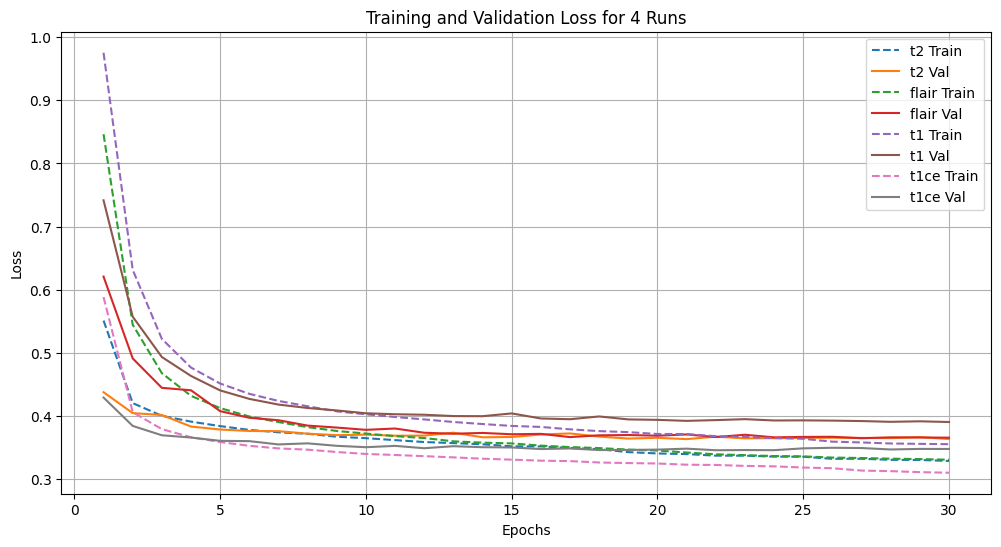

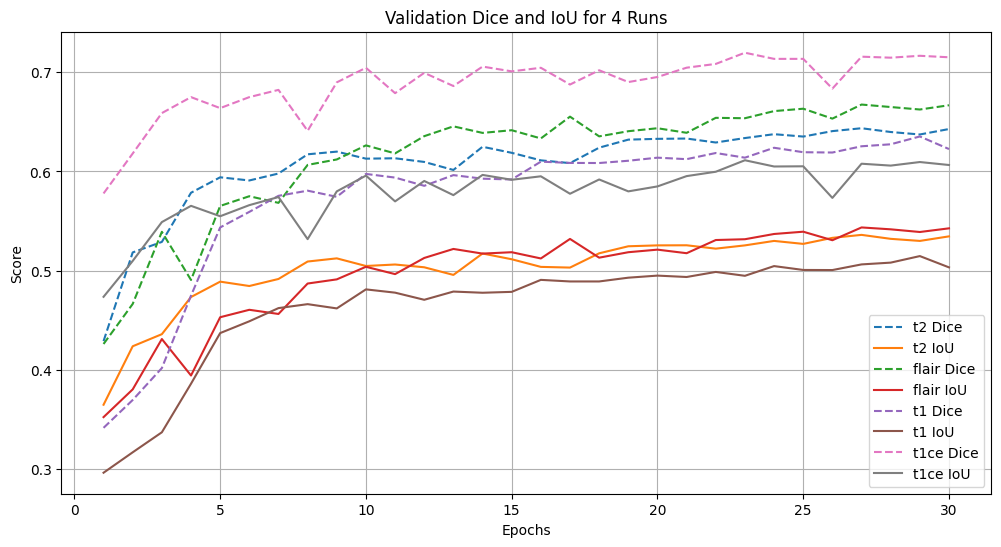

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, 31)

# Plot Train and Val Loss
plt.figure(figsize=(12,6))
for k, v in histories.items():  # .items() gives key, value
    plt.plot(epochs, v["train_loss"], label=f"{k} Train", linestyle='--')
    plt.plot(epochs, v["val_loss"], label=f"{k} Val", linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for all 4 models")
plt.legend()
plt.grid(True)
plt.show()

# Plot Val Dice and Val IoU
plt.figure(figsize=(12,6))
for k, v in histories.items():
    plt.plot(epochs, v["val_dice"], label=f"{k} Dice", linestyle='--')
    plt.plot(epochs, v["val_iou"], label=f"{k} IoU", linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Validation Dice and IoU scores for all 4 models")
plt.legend()
plt.grid(True)
plt.show()


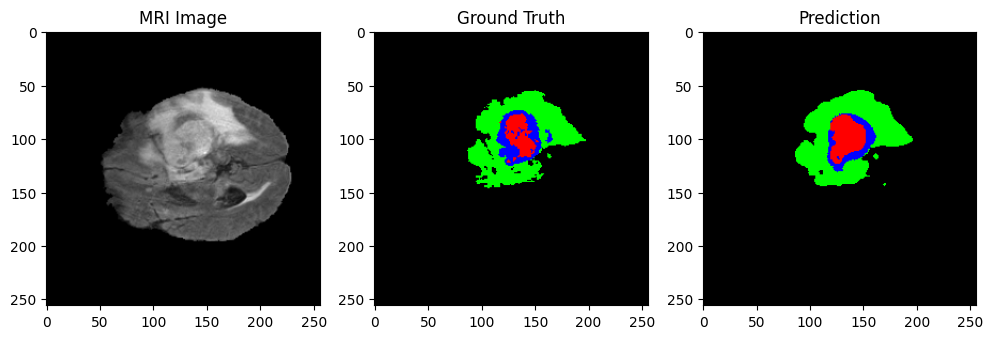

In [42]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = "cuda"

# Define colors for 4 classes (adjust if needed)
COLORS = {
    0: (0, 0, 0),       # background - black
    1: (255, 0, 0),     # class 1 - red
    2: (0, 255, 0),     # class 2 - green
    3: (0, 0, 255)      # class 3 - blue
}

def decode_mask(mask):
    """Convert mask (H,W) with class indices into RGB image"""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in COLORS.items():
        color_mask[mask == cls] = color
    return color_mask

# ---- Example prediction ----

model = get_model().to(device);
model.load_state_dict(torch.load("/kaggle/working/flair_2_unet_resnet18.pth", map_location=device))
    
dataset = BrainMRIDataset("/kaggle/input/brats20-sampled-subset-png/dataset/flair/images",
                          "/kaggle/input/brats20-sampled-subset-png/dataset/flair/masks")

model.eval()
with torch.no_grad():
    sample_img, sample_mask = dataset[0]   
    img_tensor = sample_img.unsqueeze(0).to(device)  
    pred = model(img_tensor)               
    pred_class = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

# Convert ground truth & prediction to color masks
gt_mask = sample_mask.numpy()  
gt_colored = decode_mask(gt_mask)
pred_colored = decode_mask(pred_class)

# Plot comparison
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title("MRI Image")

plt.subplot(1,3,2)
plt.imshow(gt_colored)
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred_colored)
plt.title("Prediction")
plt.show()

## Post-Training Analysis

- Model performs well on clear tumor regions but struggles on very small/blurred tumors.
- Overfitting observed after N epochs → applied Early Stopping + Data Augmentation.
- Segmentation masks show smooth tumor boundaries, but misclassification occurs in noisy regions.

### models perform reseonably well with respect to the size of dataset used and hardware constraints

Trained few more epochs in hope of improvement but no improvement observed.

In [34]:
ext_hist_flair = train_one_modality("flair", epochs=5, weights_path="/kaggle/working/flair_unet.pth")

Loading pretrained weights from /kaggle/working/flair_2_unet_resnet18.pth


Epoch 1/5: 100%|██████████| 543/543 [00:49<00:00, 11.03batch/s]


Epoch 1/5 - Train Loss: 0.3499 - Val Loss: 0.3459 - Val Dice: 0.6659 - Val IoU: 0.5557


Epoch 2/5: 100%|██████████| 543/543 [00:49<00:00, 11.06batch/s]


Epoch 2/5 - Train Loss: 0.3478 - Val Loss: 0.3447 - Val Dice: 0.6702 - Val IoU: 0.5597


Epoch 3/5: 100%|██████████| 543/543 [00:48<00:00, 11.10batch/s]


Epoch 3/5 - Train Loss: 0.3466 - Val Loss: 0.3426 - Val Dice: 0.6847 - Val IoU: 0.5769


Epoch 4/5: 100%|██████████| 543/543 [00:48<00:00, 11.09batch/s]


Epoch 4/5 - Train Loss: 0.3434 - Val Loss: 0.3449 - Val Dice: 0.6772 - Val IoU: 0.5667


Epoch 5/5: 100%|██████████| 543/543 [00:49<00:00, 11.07batch/s]


Epoch 5/5 - Train Loss: 0.3431 - Val Loss: 0.3446 - Val Dice: 0.6830 - Val IoU: 0.5723


In [35]:
ext_hist_t1 = train_one_modality("t1", epochs=7, weights_path="/kaggle/working/t1_unet.pth")

Loading pretrained weights from /kaggle/working/t1_2_unet_resnet18.pth


Epoch 1/7: 100%|██████████| 544/544 [00:49<00:00, 11.04batch/s]


Epoch 1/7 - Train Loss: 0.3756 - Val Loss: 0.3674 - Val Dice: 0.6324 - Val IoU: 0.5211


Epoch 2/7: 100%|██████████| 544/544 [00:49<00:00, 11.06batch/s]


Epoch 2/7 - Train Loss: 0.3745 - Val Loss: 0.3686 - Val Dice: 0.6271 - Val IoU: 0.5177


Epoch 3/7: 100%|██████████| 544/544 [00:49<00:00, 11.10batch/s]


Epoch 3/7 - Train Loss: 0.3713 - Val Loss: 0.3732 - Val Dice: 0.6241 - Val IoU: 0.5165


Epoch 4/7: 100%|██████████| 544/544 [00:48<00:00, 11.12batch/s]


Epoch 4/7 - Train Loss: 0.3702 - Val Loss: 0.3687 - Val Dice: 0.6277 - Val IoU: 0.5175


Epoch 5/7: 100%|██████████| 544/544 [00:49<00:00, 11.10batch/s]


Epoch 5/7 - Train Loss: 0.3687 - Val Loss: 0.3745 - Val Dice: 0.6258 - Val IoU: 0.5161


Epoch 6/7: 100%|██████████| 544/544 [00:48<00:00, 11.14batch/s]


Epoch 6/7 - Train Loss: 0.3622 - Val Loss: 0.3678 - Val Dice: 0.6395 - Val IoU: 0.5293


Epoch 7/7: 100%|██████████| 544/544 [00:48<00:00, 11.15batch/s]


Epoch 7/7 - Train Loss: 0.3595 - Val Loss: 0.3674 - Val Dice: 0.6400 - Val IoU: 0.5301


In [36]:
ext_hist_t2 = train_one_modality("t2", epochs=7, weights_path="/kaggle/working/t2_unet.pth")

Loading pretrained weights from /kaggle/working/t2_2_unet_resnet18.pth


Epoch 1/7: 100%|██████████| 544/544 [00:48<00:00, 11.24batch/s]


Epoch 1/7 - Train Loss: 0.3465 - Val Loss: 0.3439 - Val Dice: 0.6897 - Val IoU: 0.5803


Epoch 2/7: 100%|██████████| 544/544 [00:49<00:00, 11.09batch/s]


Epoch 2/7 - Train Loss: 0.3458 - Val Loss: 0.3449 - Val Dice: 0.6821 - Val IoU: 0.5716


Epoch 3/7: 100%|██████████| 544/544 [00:49<00:00, 11.05batch/s]


Epoch 3/7 - Train Loss: 0.3433 - Val Loss: 0.3441 - Val Dice: 0.6873 - Val IoU: 0.5768


Epoch 4/7: 100%|██████████| 544/544 [00:49<00:00, 11.10batch/s]


Epoch 4/7 - Train Loss: 0.3429 - Val Loss: 0.3453 - Val Dice: 0.6813 - Val IoU: 0.5703


Epoch 5/7: 100%|██████████| 544/544 [00:49<00:00, 11.09batch/s]


Epoch 5/7 - Train Loss: 0.3406 - Val Loss: 0.3479 - Val Dice: 0.6752 - Val IoU: 0.5642


Epoch 6/7: 100%|██████████| 544/544 [00:49<00:00, 11.05batch/s]


Epoch 6/7 - Train Loss: 0.3363 - Val Loss: 0.3461 - Val Dice: 0.6848 - Val IoU: 0.5761


Epoch 7/7: 100%|██████████| 544/544 [00:49<00:00, 11.02batch/s]


Epoch 7/7 - Train Loss: 0.3334 - Val Loss: 0.3448 - Val Dice: 0.6910 - Val IoU: 0.5799


In [30]:
ext_hist_t1ce = train_one_modality("t1ce", epochs=5, weights_path="/kaggle/working/t1ce_unet.pth")

Loading pretrained weights from /kaggle/working/t1ce_2_unet_resnet18.pth


Epoch 1/5: 100%|██████████| 544/544 [00:49<00:00, 11.07batch/s]


Epoch 1/5 - Train Loss: 0.3274 - Val Loss: 0.3223 - Val Dice: 0.7403 - Val IoU: 0.6326


Epoch 2/5: 100%|██████████| 544/544 [00:48<00:00, 11.12batch/s]


Epoch 2/5 - Train Loss: 0.3256 - Val Loss: 0.3197 - Val Dice: 0.7473 - Val IoU: 0.6381


Epoch 3/5: 100%|██████████| 544/544 [00:49<00:00, 10.94batch/s]


Epoch 3/5 - Train Loss: 0.3248 - Val Loss: 0.3211 - Val Dice: 0.7502 - Val IoU: 0.6417


Epoch 4/5: 100%|██████████| 544/544 [00:49<00:00, 10.97batch/s]


Epoch 4/5 - Train Loss: 0.3227 - Val Loss: 0.3195 - Val Dice: 0.7478 - Val IoU: 0.6388


Epoch 5/5: 100%|██████████| 544/544 [00:49<00:00, 10.91batch/s]


Epoch 5/5 - Train Loss: 0.3222 - Val Loss: 0.3203 - Val Dice: 0.7720 - Val IoU: 0.6666
